In [ ]:
import sys
sys.path.append("/environment/notebooks/synthetic-tweets-in-sentiment-analysis/")
import pandas as pd
from sklearn.model_selection import train_test_split
from libs.SyntheticDataGenerator import fill_missing_labels, fill_synthetic_data_percentage
from libs.SentimentClassifier import preprocess, evaluation
import torch
import torch_directml


device = torch.device('cuda' if torch.cuda.is_available() else torch_directml.device())
SYNTH_METHOD = "synonyms"
TGT_LANGUAGES = ["ru"]
BATCH_SIZE = 10
EPOCHS = 2

# data =pd.read_csv(
#     filepath_or_buffer='../data/data.csv',
#     sep='\t',
#     encoding='utf8',
#     names=["ID", "Label", "Tweet"]
#     )

pewpew =pd.read_csv(
    filepath_or_buffer=f"../data/weird_stuff.csv",
    encoding='utf8'
    )
# gpt3_data = pd.read_csv(
#     filepath_or_buffer='../data/ChatGPT.csv',
#     sep='\t',
#     encoding='utf8',
#     names=["Tweet", "Label"]
#     )

train_dataset, val_dataset = train_test_split(data, test_size=0.20, random_state=42)
print("Labelverteilung ohne Datenaugmentation: ")
print(train_dataset['Label'].value_counts(normalize=True))
#filled_data, synth_word_ratio = fill_synthetic_data_percentage(train_dataset,
#                                  percentage=2,
#                                  method=SYNTH_METHOD,
#                                 word_embedding_model=glove_model,
#                                  tgt_languages=TGT_LANGUAGES,
#                                  coverage_percentage=1)
print("Labelverteilung mit Datenaugmentation: ")
#print(f"Synth word ratio: {synth_word_ratio:.2f}")
train_dataloader = preprocess(pewpew, batch_size=BATCH_SIZE)
val_dataloader = preprocess(val_dataset, batch_size=BATCH_SIZE)

evaluation(train_dataloader, val_dataloader, epochs=EPOCHS, device=device)
filled_data_without_duplicates = filled_data.drop_duplicates(subset='Tweet', keep="first")
print(f"{filled_data.size - filled_data_without_duplicates.size} entries are duplicates")

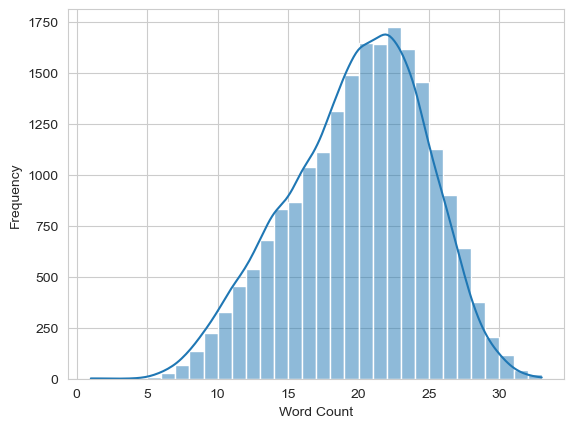

In [1]:
from nltk.tokenize import TweetTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

tweet_tokenizer = TweetTokenizer()

data =pd.read_csv(
    filepath_or_buffer='../data/data.csv',
    sep='\t',
    encoding='utf8',
    names=["ID", "Label", "Tweet"]
    )
def token_pipeline(tweet):
    tweet = tweet.lower()
    tokens = tweet_tokenizer.tokenize(tweet)
    return tokens

data["Tweet_Token"] = data["Tweet"].apply(token_pipeline)
data["Tweet_Token"] = data["Tweet_Token"].apply(lambda x: [word for word in x if word not in string.punctuation])
data['Word_Count'] = data['Tweet_Token'].apply(len)
#data["Word"] = data.groupby('Label')['Word_Count'].mean()

sns.histplot(data['Word_Count'],kde=True, bins=32)
#plt.title('Histogram of Tweet Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

stopwords_list = set(stopwords.words('english'))
negative_data = data[data["Label"] == "negative"]
neutral_data = data[data["Label"] == "neutral"]
positive_data = data[data["Label"] == "positive"]
print(negative_data.size)
text = ' '.join(neutral_data['Tweet'])
# Tokenize the text into individual words
tokens = word_tokenize(text)

# Remove stopwords from the tokens
filtered_tokens = [word for word in tokens if word.lower() not in stopwords_list and word not in string.punctuation]

# Calculate the frequency distribution of words
freq_dist = FreqDist(filtered_tokens)

# Get the top 15 most frequent words
top_15_words = freq_dist.most_common(50)

# Print the top 15 words
for word, frequency in top_15_words:
    print(word, frequency)

In [ ]:
data =pd.read_csv(
    filepath_or_buffer='../data/Sentiment140.csv',
    encoding='latin-1',
    names=["Label", "ID", "Timestamp", "Query", "Username", "Tweet"]
    )

negative_data = data[data["Label"] == "negative"]
neutral_data = data[data["Label"] == "neutral"]
positive_data = data[data["Label"] == "positive"]
filled_data = pd.concat([negative_data.sample(1000), neutral_data.sample(1000), positive_data.sample(1000)])
data = data.sample(frac=1)
data = data.sample(50000)
data.head()

In [ ]:
# Count the occurrences of each label
label_counts = data['Label'].value_counts()
print(label_counts)
# Set the desired count for each label
desired_count = min(label_counts)
# Filter the DataFrame to have the same count of labels
filtered_df = data.groupby('Label').apply(lambda x: x.sample(desired_count))

# Reset the index of the filtered DataFrame
#filtered_df = filtered_df.reset_index(drop=True)

# Display the filtered DataFrame
filtered_df.head(50)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
palette ={"neutral": "orange","positive": "red","negative": "blue",}
# Annahme: Sie haben einen DataFrame namens "train_data" mit einer Spalte "Label", die die Labels enthält
# und die Werte der Labels sind in Form von Zeichenketten (Strings) gegeben.

# Verwenden Sie die "value_counts()" Funktion, um die Anzahl der Vorkommen jedes Labels zu ermitteln
labels = data['Label']
label_counts = labels.value_counts()

# Erstellen Sie ein Kuchendiagramm der Label-Verteilung mit Seaborn
plt.figure(figsize=(8, 6))  # Festlegen der Diagrammgröße
textprops={'color':"black", 'size': 15}
# Erstellen des Kuchendiagramms
pie_chart = plt.pie(label_counts, labels=label_counts.index, 
        autopct='%1.1f%%', 
        colors=palette.values(), textprops=textprops)
pie_chart[0][0].get_figure().savefig("../figures/word_distribution.svg")

plt.show()


In [ ]:
def label_to_number(label):
    label_mapping = {
        'negative' : 0,
        'neutral' : 1,
        'positive' : 2
    }

    return label_mapping[label]


labels = labels.apply(lambda x : label_to_number(x))

In [ ]:
import torch
from transformers import AutoTokenizer


# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_SEQUENCE_LENGTH = 100


# Tokenize and pad the tweets
input_ids = []
attention_masks = []


def tweet_pipeline(tweet):
    encoded_dict = tokenizer.encode_plus(tweet,
                                         add_special_tokens = True,
                                         padding= 'max_length',
                                         return_attention_mask = True,
                                         return_tensors = 'pt')
    input_ids.append(encoded_dict["input_ids"])
    attention_masks.append(encoded_dict["attention_mask"])

tweets = tweets.apply(lambda tweet : tweet_pipeline(tweet))

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [ ]:
from libs.SentimentClassifier import k_cross_fold_validation, evaluation
from transformers import logging
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split


seed_val = 42
k = 2
batch_size = 5
epochs = 2
device = "cpu"

logging.set_verbosity_error()
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.4 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )




#k_cross_fold_validation(dataset,k,epochs,batch_size,device)
evaluation(train_dataloader,validation_dataloader,epochs,device)

In [ ]:
class_mapping = {
    0: 'neutral',
    1: 'positive',
    2: 'negative'
}

all_cm = [i['Valid. Confusion Matrix'] for i in training_stats]

avrg_confusion_matrix = torch.ceil(torch.mean(torch.stack(all_cm) , dim=0))

plt.figure(figsize=(15,10))

class_names = list(class_mapping.values())
df_cm = pd.DataFrame(avrg_confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
